In [1]:
%matplotlib inline

# Module 10 - Programming Assignment (Summer)

## Directions

There are general instructions on Blackboard and in the Syllabus for Programming Assignments. This Notebook also has instructions specific to this assignment. Read all the instructions carefully and make sure you understand them. Please ask questions on the discussion boards or email me at `EN605.445@gmail.com` if you do not understand something.

<div style="background: mistyrose; color: firebrick; border: 2px solid darkred; padding: 5px; margin: 10px;">
You must follow the directions *exactly* or you will get a 0 on the assignment.
</div>

You must submit *only* your IPython notebook to Blackboard. It should be cleanly executed and named:

```
<jhed_id>.ipynb
```

An HTML version of the notebook will be generated and graded and the notebook will be used only for reference. To see what the HTML version of your notebook will look like, apply the following command:

> ipython nbconvert <jhed_id>.ipynb

or use the File menu.

# The Problem

Last week we left our agent with a simple logistic regression that it could use to classify a picture from its cheap visual "sensor" as hills or not hills. We *could* make a logistic regression for each train type (hills/not hills, plains/not plains, swamp/not swamp, forest/not forest) and pick the one with the largest probability but that's exactly the kind of a problem a Multi-Layer Perceptron (MLP) Artificial Neural Network (ANN) was designed to solve.

Here are the "pure" images again:

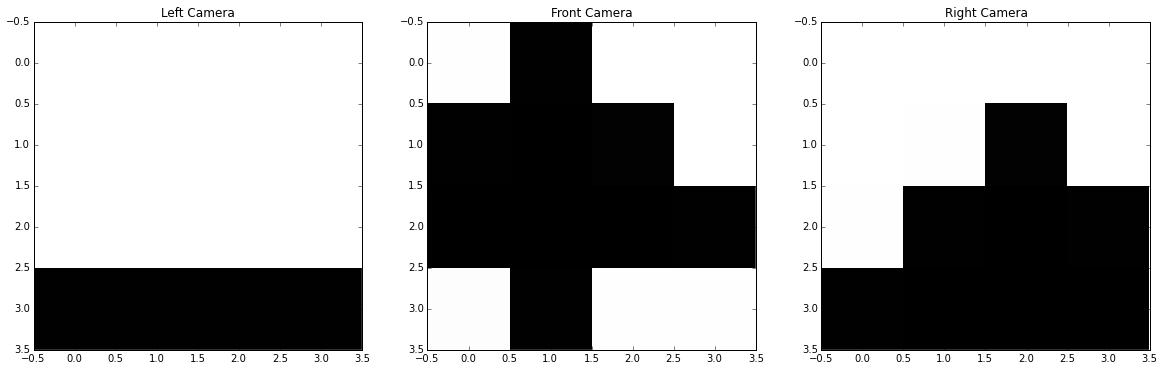

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random, math

plain =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 1.0, 1.0, 1.0]
forest = [0.0, 1.0, 0.0, 0.0,1.0, 1.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0,0.0, 1.0, 0.0, 0.0]
hills =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 1.0, 0.0,0.0, 1.0, 1.0, 1.0,1.0, 1.0, 1.0, 1.0]
swamp =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 0.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0]

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)
pixels = np.array([255 - p * 255 for p in plain], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Left Camera")
axes.imshow(pixels, cmap='gray', interpolation='None')

axes = figure.add_subplot(1, 3, 2)
pixels = np.array([255 - p * 255 for p in forest], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Front Camera")
axes.imshow(pixels, cmap='gray', interpolation='None')

axes = figure.add_subplot(1, 3, 3)
pixels = np.array([255 - p * 255 for p in hills], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Right Camera")
axes.imshow(pixels, cmap='gray', interpolation='None')

plt.show()
plt.close()

which would be plains, forest and hills respectively.

## The Assignment

For this programming assignment your tasks are:

1. Write an ANN regression that simply determines what kind of terrain it is. This is a multi-class problem.
2. You will also evaluate your model for at least 3 different numbers of nodes in the hidden layer (2, 4, 8) and determine which one has the lowest *error rate*.

For a starting point, you can refer to **module-10-pseudocode.pdf** and the Self-Check.

## Data

As before, we have clean examples of the different types of terrain but based on the location, the registration can be a bit off for some of the types and the visual sensor is often blurry.

Here are the clean examples with different registrations: 

In [3]:
clean_data = {
    "plains": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, "plains"]
    ],
    "forest": [
        [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, "forest"],
        [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, "forest"]
    ],
    "hills": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, "hills"]
    ],
    "swamp": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "swamp"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, "swamp"]        
    ]
}

Let's create a function that allows us to view any of these:

In [4]:
def view_sensor_image( data):
    figure = plt.figure(figsize=(4,4))
    axes = figure.add_subplot(1, 1, 1)
    pixels = np.array([255 - p * 255 for p in data[:-1]], dtype='uint8')
    pixels = pixels.reshape((4, 4))
    axes.set_title( "Left Camera:" + data[-1])
    axes.imshow(pixels, cmap='gray', interpolation='None')
    plt.show()
    plt.close()

"I think that I shall never see a thing so lovely as a tree."

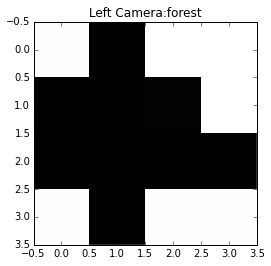

In [5]:
view_sensor_image( clean_data[ "forest"][0])

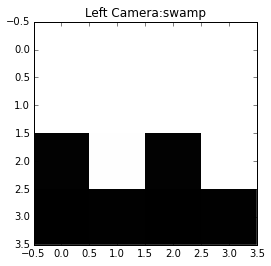

In [6]:
view_sensor_image( clean_data["swamp"][0])

The data that comes in, however, is noisy. The values are never exactly 0 and 1. In order to mimic this we need a `blur` function.

We will assume that noise is normally distributed. For values that should be 0, the noisy values are distributed $N(0.10, 0.05)$. For values should be 1, the noisy values are distributed $N(0.9, 0.10)$.

In [7]:
def blur( data):
    def apply_noise( value):
        if value < 0.5:
            v = random.gauss( 0.10, 0.05)
            if v < 0.0:
                return 0.0
            if v > 0.75:
                return 0.75
            return v
        else:
            v = random.gauss( 0.90, 0.10)
            if v < 0.25:
                return 0.25
            if v > 1.00:
                return 1.00
            return v
    noisy_readings = [apply_noise( v) for v in data[0:-1]]
    return noisy_readings + [data[-1]]

We can see how this affects what the agent *actually* sees.

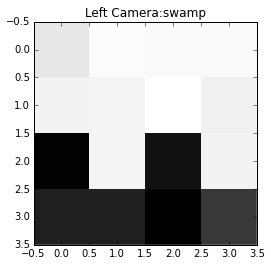

In [8]:
view_sensor_image( blur( clean_data["swamp"][0]))

You are going to want to write four (4) functions:

1. `generate_data`
2. `learn_model`
3. `apply_model`
4. `generate_validation_curves`


### `generate_data`

With the clean examples and the `blur` function, we have an unlimited amount of data for training and testing our classifier, an ANN that determines if a sensor image is hills, swamp, forest or plains.

In classification, there is a general problem called the "unbalanced class problem". In general, we want our training data to have the same number of classes for each class. This means you should probably generate training data with, say, 100 of each type.

But what do we do about the class label with the neural network?

In this case, we can do "one hot". Instead of `generate_data` outputing a single 0 or 1, it should output a vector of 0's and 1's so that $y$ is now a vector as well as $x$. We can use the first position for hill, the second for swamp, the third for forest and the fourth for plains:

```
[0, 1, 0, 0]
```

what am I? swamp.

Unlike logistic regression, you should set the *biases* inside the neural network (the implict $x_0$ = 1) because there are going to be lot of them (one for every hidden and output node).

`generate_data` now only needs to take how many you want of each class:

`generate_data( clean_data, 100)`

generates 100 hills, 100 swamp, 100 forest, 100 plains and transforms $y$ into the respective "one hot" encoding.

### `learn_model`

`learn_model` is the function that takes in training data and actually learns the ANN. If you're up to it, you can implement a vectorized version using Numpy but you might start with the loopy version first.

*In the lecture, I mentioned that you usually should mean normalize your data but you don't need to do that in this case because the data is already on the range 0-1.*

You should add a parameter to indicate how many nodes the hidden layer should have.

When verbose is True, you should print out the error so you can see that it is getting smaller.

When developing your algorithm, you need to watch the error so you'll set verbose=True to start. You should print it out every iteration and make sure it is declining. You'll have to experiment with both epsilon and alpha; and it doesn't hurt to make alpha adaptive (if the error increases, make alpha = alpha / 10).

When you know that your algorithm is working, change your code so that the error is printed out only every 1,000 iterations (it takes a lot of iterations for this problem to converge, depending on your parameter values--start early).

`learn_model` returns the neural network. The hidden layer will be one vector of thetas for each hidden node. And the output layer will have its own thetas, one for each output (4 in this case). Return it as a Tuple: (List of List, List of List).

### `apply_model`

`apply_model` takes the ANN (the model) and either labeled or unlabeled data. If the data is unlabeled, it will return predictions for each observation as a List of Tuples of the inferred value (0 or 1) and the actual probability (so something like (1, 0.73) or (0, 0.19) so you have [(0, 0.30), (1, 0.98), (0, 0.87), (0, 0.12)]. Note that unlike the logistic regression, the threshold for 1 is not 0.5 but which value is largest (0.98 in this case).

If the data is labeled, you will return a List of List of Tuples of the actual value (0 or 1) and the predicted value (0 or 1). For a single data point, you'll have the pairs of actual values [(0, 1), (0, 0), (0, 0), (1, 0)] is a misclassification and [(0, 0), (0, 0), (1, 1), (0, 0)] will be a correct classification. Then you have a List of *those*, one for each observation.

### `generate_validation_curves`

The `generate_validation_curves` is going to be a bit different than the confusion matrix version last week. It should take the information required to plot validation curves over the train and test sets for the specified parameter values.

So basically, you have:

1. generate training set
2. generate test set
3. loop over [2, 4, 8]
    1. train model and apply to train data, calculate error rate.
    2. apply to test data and calculae error rate.
    3. plot both curves.

The net results should be one plot of 2 curves over 3 parameter values. Please state in a markdown field afterwards which number of hidden nodes had the lowest error rate.

**As always when working with Lists or Lists of Lists, be very careful when you are modifying these items in place that this is what you intend (and not to be modifying a copy)**

---

In [9]:
terrainList = ['hills', 'swamp' ,'forest' , 'plains']

def sigm(x):
    return 1.0 / ( 1 + np.exp(-x) )

def mmult(*args):
    return reduce(np.multiply, args)

def feedForward(x, wtHidd, wtOut):
    yHatHidd = np.vstack(( sigm(wtHidd * x), np.matrix(1) ))
    yHat = sigm(wtOut * yHatHidd)
    return yHatHidd, yHat

---

Put your helper functions above here.

## Main Functions

Use `generate_data` to generate 10 blurred "hills" examples with balanced (same number of) "non hills" examples to see that the function is working.

In [10]:
################################################################################
def generate_data( data, n):
    out = list()
    for idx,tp in enumerate(terrainList):
        for c in xrange(n):
            x = blur(data[tp][random.randrange(len(data[tp]))])
            y = [1 if i==idx else 0 for i in xrange(4)]
            out.append(np.matrix( x[:-1] + [1] + y ))
    random.shuffle(out)
    return out

results = generate_data( clean_data, 10)
for result in results:
    print result

[[ 0.          0.16049019  0.10311244  0.          0.11196324  0.14947093
   0.09760424  0.14988364  0.13769946  0.05574752  0.0657569   0.08749137
   0.97839418  1.          0.91523632  1.          1.          0.          0.
   0.          1.        ]]
[[ 0.          0.09585814  0.0967895   0.16044108  0.81778187  0.04126375
   0.09557997  0.17520627  0.95670734  0.96654332  0.05633241  0.14709099
   0.80427243  0.96388033  0.8768291   0.08754392  1.          1.          0.
   0.          0.        ]]
[[ 0.12663393  0.08562711  0.01810438  0.96965028  0.10234209  0.17674279
   0.9142603   0.91236265  0.17151024  1.          0.92766122  1.
   0.15727298  0.06402734  0.04018302  0.78174197  1.          0.          0.
   1.          0.        ]]
[[ 0.          0.          0.09089722  0.12762877  0.08876559  0.08931093
   0.10414845  0.16655549  0.13224067  0.94234359  0.11099685  0.72607978
   0.96223307  0.77002567  0.82737625  0.89308158  1.          0.          1.
   0.          0.   

Use `learn_model` to learn a ANN model for classifying sensor images as hills, swamps, plains or forest. Use your `generate_data` function to generate a training set with 100 examples for each. **Set Verbose to True**

In [11]:
def ffbp(data, wtHidd, wtOut, a):
    x, y = np.split( data.T, [-4])
    #print wtHidd * x
    yHatHidd, yHat = feedForward(x, wtHidd, wtOut)
    
    err = y-yHat
    deltaOut = mmult(err, 1-yHat, yHat)
    outChg = (a * deltaOut) * yHatHidd.T
    
    deltaHidd = mmult(1-yHatHidd, yHatHidd, (deltaOut.T * wtOut).T)
    hiddChg = (a * deltaHidd[:-1]) * x.T
    
    return outChg, hiddChg, np.linalg.norm(err)/math.sqrt(y.size), err
################################################################################

def initTheta(dataDim, nHidd, nOut, xMax):
    hidden = (np.random.rand(nHidd, dataDim-nOut)) *xMax / (dataDim-nOut)
    outter = (np.random.rand(nOut, nHidd+1)) * xMax / nHidd
    return np.matrix(hidden), np.matrix(outter)

def learn_model( data, nHidd, alpha, eps, verbose=False):
    wtHidd, wtOut = initTheta(data[0].shape[1], nHidd, 4, 0.5)
    #wtHidd = np.matrix(np.random.rand(nHidd, data[0].shape[1]-nO#ut) / nHidd)
    #wtOut = np.matrix(np.random.rand(nOut, nHidd+1))
    
    #print wtHidd * data[0].T[:-4]
    #print wtOut * np.vstack(( sigm(wtHidd * data[0].T[:-4]), np.matrix(1) ))
    
    rd = 0
    RMSEdiff = np.zeros(10)
    RMSE, lastRMSE = 1, 0
    while abs(RMSE-lastRMSE) > eps and rd<10 and RMSE>0.05:
        lastRMSE = RMSE
        for n,d in enumerate(data):
            wtOutChg, wtHiddChg, RMSE, err = ffbp(d, wtHidd, wtOut, alpha)
            wtOut, wtHidd = (wtOut+wtOutChg, wtHidd+wtHiddChg) # update weights
        RMSEdiff = np.hstack( (RMSE-lastRMSE, RMSEdiff[:-1]) )
        if (RMSEdiff>0).sum() > 3 and alpha > 0.05:
            alpha = (alpha/1.5)
        if (RMSEdiff[:5] > 0).sum() > 3:
            break
        
        if rd%10==0 and verbose: # print every 50
            print('Round #%u, RMSE: %f, alpha: %f'%(rd,RMSE,alpha))
        rd += 1
        
    print('Final round #%u, RMSE: %f, alpha: %f' % (rd-1,RMSE, alpha) )
    return wtHidd.tolist(), wtOut.tolist()


train_data = generate_data( clean_data, 100)
model = learn_model( train_data, 2, 2, 1e-7, True)

Round #0, RMSE: 0.092303, alpha: 2.000000
Final round #5, RMSE: 0.101994, alpha: 1.333333


Use `generate_data` to generate 100 blurred examples of each terrain and use this as your test data. Print out the first 10 results, one per line.

In [12]:
test_data = generate_data( clean_data, 100)
for x in xrange(10):
    print test_data[x]


def apply_model( model, test_data, labeled=False):
    wtHidd, wtOut = np.matrix(model[0]), np.matrix(model[1])
    categ, prob, actual = list(), list(), list()
    for n, d in enumerate(test_data):
        x, y = np.split( d.T, [-4])
        yHat = feedForward(x, wtHidd, wtOut)[1]
        prob.append(yHat.max())
        categ.append(yHat.argmax())
        actual.append(y.argmax())
        
    if labeled:
        return zip(categ, actual)
    else:
        return zip(categ, prob)


results = apply_model( model, test_data)
#print results
print sum([1 if x[0]==x[1] else 0 for x in results])

[[ 0.18751495  0.11776331  0.03540578  0.12175536  0.06581321  0.11003249
   0.07087239  0.14917897  0.85828348  0.13196549  0.91394696  0.
   0.83439826  0.90109589  0.93409178  0.92251678  1.          0.          1.
   0.          0.        ]]
[[ 0.03342064  0.13564127  0.07124922  0.15146216  0.05848653  0.13110934
   0.12020286  0.01415881  0.99488992  0.00533245  1.          0.04427141
   0.98888326  0.87537617  0.95977306  0.69940699  1.          0.          1.
   0.          0.        ]]
[[ 0.11016684  0.07803465  0.05024349  0.05714789  0.10080561  0.14528489
   0.14309282  0.06923325  0.19424936  0.06784195  0.16181771  0.08245469
   0.93075564  1.          1.          0.8455788   1.          0.          0.
   0.          1.        ]]
[[ 0.08788884  0.14064584  0.10020714  0.18058859  0.18723385  0.
   0.77431086  0.10672468  0.08241978  0.84671008  0.8094103   0.84098403
   0.87850265  1.          0.76261287  0.95063496  1.          1.          0.
   0.          0.        ]]


Now that you're pretty sure your algorithm works (the error rate during training is going down, and you can evaluate `apply_model` results for its error rate, learn validation curves:

In [13]:
def generate_validation_curves(hyperParm, data):
    plt.plot(hyperParm, zip(*data)[0], label='Training Data')
    plt.plot(hyperParm, zip(*data)[1], label='Testing Data')
    plt.legend(loc=0)
    plt.axis([min(hyperParm)-0.2, max(hyperParm)+0.2, 0, 1.05])
    plt.show()
    

Final round #9, RMSE: 0.180066, alpha: 2.000000
Final round #4, RMSE: 0.043773, alpha: 2.000000
Final round #4, RMSE: 0.043797, alpha: 2.000000
Final round #4, RMSE: 0.044415, alpha: 2.000000
Final round #4, RMSE: 0.042590, alpha: 2.000000


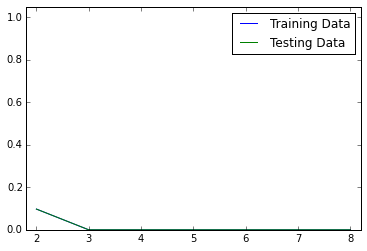

In [14]:
################################################################################
def errorRate(labeldResult):
    discord = sum([1 if pred!=act else 0 for pred,act in labeldResult])
    return discord / (len(labeldResult)+0.0)

train = generate_data( clean_data, 100)
test  = generate_data( clean_data, 100)

hyperParm = [2, 3, 4, 6, 8]
valCurveData = list()
for n in hyperParm:
    model = learn_model( train, n, 2, 1e-7, False)
    train_results = apply_model( model, train, True)
    test_results = apply_model( model, test, True)
    valCurveData.append(( errorRate(train_results),errorRate(test_results) ))

generate_validation_curves(hyperParm, valCurveData)

which number of hidden nodes is best? same